In [1]:
import pandas as pd
import joblib
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, precision_recall_curve
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../../data/processed/imputed_dataset.csv")

#add features present in synthetic dataset that are absent in imputed
df["default_x_default_last_6"] = df["prev_defaults"] * df["default_in_last_6months"]
df["prev_defaults_squared"] = df["prev_defaults"] ** 2
df["credit_ratio_limit"] = df["credit_limit_used(%)"] / df["credit_score"]
df["credit_score_x_credit_limit_used"] = df["credit_score"] * df["credit_limit_used(%)"]
df["credit_limit_used_squared"] = df["credit_limit_used(%)"] ** 2
df["credit_score_squared"] = df["credit_score"] ** 2

logreg_features = ['credit_limit_used(%)', 'credit_score', 'prev_defaults', 
            'default_in_last_6months','default_x_default_last_6', 
            'prev_defaults_squared', 'credit_ratio_limit', 'credit_score_x_credit_limit_used',
            'credit_limit_used_squared', 'credit_score_squared']

rf_cat_features = [
    'credit_limit_used(%)',
    'credit_score',
    'prev_defaults',
    'default_in_last_6months',
    'no_of_children',
    'owns_car',
    'no_of_days_employed',
    'yearly_debt_payments',
    'migrant_worker',
    'total_family_members',
    'credit_score_squared',
    'credit_limit_used_squared',
    'credit_score_x_credit_limit_used',
    'credit_ratio_limit'
]

X_logreg = df[logreg_features]
X_rf_cat = df[rf_cat_features]
y = df["credit_card_default"]

scaler = StandardScaler()
X_logreg = scaler.fit_transform(X_logreg)

In [3]:
logreg = joblib.load("../../trained_models/logreg_credit_default.pkl")
rf = joblib.load("../../trained_models/rf_credit_default.pkl")

catboost = CatBoostClassifier()
catboost.load_model("../../trained_models/catboost_credit_default.cbm")

models = {
    "Logistic Regression": (logreg, X_logreg),
    "Random Forest": (rf, X_rf_cat),
    "CatBoost": (catboost, X_rf_cat)
}

figures_dir = "../../figures"

In [4]:
pred_logreg = logreg.predict(X_logreg)
proba_logreg = logreg.predict_proba(X_logreg)[:, 1]

pred_rf = rf.predict(X_rf_cat)
proba_rf = rf.predict_proba(X_rf_cat)[:, 1]

pred_cat = catboost.predict(X_rf_cat).astype(int)
proba_cat = catboost.predict_proba(X_rf_cat)[:, 1]

In [5]:
def get_scores(y_true, preds, probs):
    return {
        "precision": precision_score(y_true, preds),
        "recall": recall_score(y_true, preds),
        "f1": f1_score(y_true, preds),
        "roc_auc": roc_auc_score(y_true, probs)
    }

In [6]:
results = {
    "Logistic Regression": get_scores(y, pred_logreg, proba_logreg),
    "Random Forest": get_scores(y, pred_rf, proba_rf),
    "CatBoost": get_scores(y, pred_cat, proba_cat)
}

print(pd.DataFrame(results).T)

                     precision    recall        f1   roc_auc
Logistic Regression   0.293529  1.000000  0.453842  0.993580
Random Forest         0.968591  0.975926  0.972245  0.999594
CatBoost              0.876600  0.981877  0.926257  0.998939


C:\Users\Trevor\AppData\Local\Temp\ipykernel_41312\1993035027.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


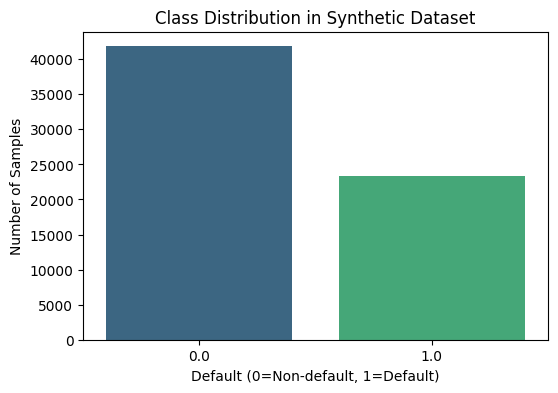

In [21]:
df = pd.read_csv("../../data/processed/imputed_dataset_with_synthetic.csv")

# Count class occurrences
class_counts = df['credit_card_default'].value_counts()

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution in Synthetic Dataset")
plt.xlabel("Default (0=Non-default, 1=Default)")
plt.ylabel("Number of Samples")
plt.savefig("../../figures/synthesized_class_dist.png")
plt.show()
plt.close()

In [8]:
for name, (model, X) in models.items():
    # Predict
    y_pred = model.predict(X)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    else:  # CatBoost
        y_prob = model.predict_proba(X)[:, 1]
    
    # ---------------- Confusion Matrix ----------------
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax)
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{figures_dir}/{name.lower().replace(' ', '_')}_confusion_matrix_imputed.png")
    plt.close()
    
    # ---------------- ROC Curve ----------------
    fig, ax = plt.subplots(figsize=(5,4))
    RocCurveDisplay.from_predictions(y, y_prob, ax=ax)
    plt.title(f"{name} ROC Curve")
    plt.savefig(f"{figures_dir}/{name.lower().replace(' ', '_')}_roc_curve_imputed.png")
    plt.close()
    
    # ---------------- Precision-Recall Curve ----------------
    precision, recall, thresholds = precision_recall_curve(y, y_prob)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.plot(recall, precision, marker='.')
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.title(f"{name} Precision-Recall Curve")
    plt.savefig(f"{figures_dir}/{name.lower().replace(' ', '_')}_precision_recall_curve_imputed.png")
    plt.close()